# TP 4 Regression logistique avec régularisation
Dans ce TP, nous aimerions faire une classification binaire en utilisant la régression.

Pour ce faire, nous étudierons un ensemble de données avec la variable  (y) representant la commercialisation d'un produit et les caractéristiques (X) representant les résultat des tests de qualité test 1 et test 2 du produit.

La prédiction se fera avec l'agorithme de descente du gradient avec régularisation.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(118, 3)

Dans ces données (data), la première colonne represente la première note, la deuxieme colonne la deuxième note et la troisième colonne represente la commercialisation (1 oui 0 non).

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,0:2]))
y = data[:, 2]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (118, 3)  y  (118, 1)


# Transformation de données
Dans cette partie, nous aimerions transformer nos données afin d'avoir une fonction polynomiale de degrée 6.

La fonction sera:

$x_0=1$

$x_1=x_1$

$x_2=x_2$

$x_3={x_1}^2$

$x_4={x_1}x_2$

$x_5={x_2}^2$

$x_6={x_1}^3$

$x_7={x_1}^2 x_2$

$x_8= x_1 {x_2}^2$

$x_9= {x_2}^3$

...


Pour un polynme de degrée 6 à 2 variables nous aurons 28 caracteristiques

**Question**: comment avons nous trouvé ce chiffre?


**Astuce**: référez vous aux probabilités

On utilise une méthode de dénombrement inspirée des probabilités, appelée **combinatoire avec répétition**.

Le but est de compter les monômes dans un polynôme de degré 6 à 2 variables \(x\^i) et \(y\^j), c’est-à-dire les couples \(i, j\) tels que :
$$
i + j \leq 6
$$

Ce nombre est donné par la formule :
$$
\binom{6 + 2}{2} = \binom{8}{2} = 28
$$

Donc, il y a **28 monômes possibles**.


In [ ]:
def mapping(X): 
    
    cols = 28
    degree=7
    outX= np.ones((X.shape[0],cols))
    X1=X[:,1]
    X2=X[:,2]
    k=0
    for i in range(degree):
        for j in range(i+1):
            outX[:, k] = np.power(X1,i-j)*(np.power(X2,j));
            k=k+1
    return outX    


In [6]:
X2=mapping(X)
X2.shape

(118, 28)

## Pourquoi faire cette tranformation polynomiale a degree 6
- La régression logistique classique est linéaire dans l’espace des caractéristiques
- Donc si les données ne sont pas séparables linéairement, elle ne va pas bien fonctionner. D’où l’idée est de tranformer les features d’origine en une version enrichie
- Ce dernier vas nous aider a tracer une courbe de decision non lineaire comme par exemple dans ce cas on doit avoir un cercle pour qu'on puisse distinguer entre les deux classes

# Descente du Gradient : Préparation des fonctions

0- Fonction mpgistique (Sigmoid)

In [7]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))
 

1- Calcul du coût

Cette fonction servira à calculer le cout $J(\theta_0,\theta_1)$

$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \Theta_j^2$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\Theta_j$ for $j\geq 1$

Elle prendra l'ensemble de données d'apprentissage en entrée ainsi que les paramètres définis initialement

In [8]:
def computeCostReg(X, y, theta, lambda_):
    m = len(y)  # Nombre d'exemples d'entraînement
    h = Sigmoid(X @ theta)  # prédictions

    # Calcul du terme de log-vraisemblance
    cost = (1/m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    # Terme de régularisation (on ne régularise pas theta[0])
    reg = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
    J = cost + reg

    return J

2- Fonction de la descente du gradient

Cette fonction mettra à jour les paramètres $\theta_0,\theta_1$ jusqu'à convergence: atteinte du nombre d'itérations max, ou dérivée assez petite.

In [9]:
def gradientDescent(X, y, theta, alpha, iterations, lambda_=0):
    # garder aussi le cout à chaque itération 
    # pour afficher le coût en fonction de theta0 et theta1
    m = len(y)  # nombre d'exemples
    J_history = []  # pour stocker le coût à chaque itération
    theta_history = []  # pour stocker les valeurs de theta à chaque itération
    for _ in range(iterations):
        h = Sigmoid(X @ theta)
        gradient = (1/m) * X.T @ (h - y) # Calcul du gradient 
        if lambda_ > 0: # Ajout de la régularisation sauf pour theta[0]
            gradient[1:] += (lambda_ / m) * theta[1:] 
        theta -= alpha * gradient
        theta_history.append(theta.copy())  # stocker le theta actuel
        J_history.append(computeCostReg(X, y, theta, lambda_))
    
    return theta, J_history, theta_history

# Descente du Gradient : Appel des fonctions

Initialisation de $\theta_0$ et $\theta_1$

In [10]:
n=X.shape[1]
theta = np.zeros((n, 1))
theta

array([[0.],
       [0.],
       [0.]])

Calculer le cout initial

In [11]:
initialCost=computeCostReg(X, y, theta, 0)
print(initialCost)

0.6931471805599454


Appel des la fonction de calcul du gradient

In [ ]:
# paramètres
iterations = 1500
alpha = 0.01

# paramètre de regression
lambdaa = 1

# Appel
theta, J, theta_history = gradientDescent(X, y, theta, alpha, iterations)
theta_history

[array([[-8.47457627e-05],
        [-1.87880932e-04],
        [-7.77711864e-07]]),
 array([[-1.69253575e-04],
        [-3.75634022e-04],
        [-1.52800926e-06]]),
 array([[-2.53524063e-04],
        [-5.63259378e-04],
        [-2.25101363e-06]]),
 array([[-3.37557848e-04],
        [-7.50757111e-04],
        [-2.94684603e-06]]),
 array([[-4.21355553e-04],
        [-9.38127331e-04],
        [-3.61562717e-06]]),
 array([[-5.04917798e-04],
        [-1.12537015e-03],
        [-4.25747736e-06]]),
 array([[-5.88245201e-04],
        [-1.31248567e-03],
        [-4.87251658e-06]]),
 array([[-6.71338379e-04],
        [-1.49947401e-03],
        [-5.46086443e-06]]),
 array([[-7.54197948e-04],
        [-1.68633527e-03],
        [-6.02264012e-06]]),
 array([[-8.36824520e-04],
        [-1.87306956e-03],
        [-6.55796252e-06]]),
 array([[-9.19218709e-04],
        [-2.05967699e-03],
        [-7.06695015e-06]]),
 array([[-1.00138112e-03],
        [-2.24615768e-03],
        [-7.54972113e-06]]),
 arr

Traçage de la fonction du coût

Notons que $\theta^T  x$ est équivalent à $X  \theta $ où $X= \begin{pmatrix}
..(x^{(1)})^T..\\
..(x^{(2)})^T..\\
.\\
.\\
.\\
..(x^{(m)})^T..
\end{pmatrix} $

# Dessin de la limite de decision (Descision Boundary)
Dans cette partie, nous aimerions dessiner la ligne separatrice d nos données

In [13]:
X2

array([[ 1.00000000e+00,  5.12670000e-02,  6.99560000e-01, ...,
         6.29470940e-04,  8.58939846e-03,  1.17205992e-01],
       [ 1.00000000e+00, -9.27420000e-02,  6.84940000e-01, ...,
         1.89305413e-03, -1.39810280e-02,  1.03255971e-01],
       [ 1.00000000e+00, -2.13710000e-01,  6.92250000e-01, ...,
         1.04882142e-02, -3.39734512e-02,  1.10046893e-01],
       ...,
       [ 1.00000000e+00, -4.84450000e-01,  9.99270000e-01, ...,
         2.34007252e-01, -4.82684337e-01,  9.95627986e-01],
       [ 1.00000000e+00, -6.33640000e-03,  9.99270000e-01, ...,
         4.00328554e-05, -6.31330588e-03,  9.95627986e-01],
       [ 1.00000000e+00,  6.32650000e-01, -3.06120000e-02, ...,
         3.51474517e-07, -1.70067777e-08,  8.22905998e-10]])

In [14]:
def drawCircle(Data):
    # Calculer les theta pour le dataset donné
    thetas = np.zeros((Data.shape[1], 1))
    # Appliquer le 
    thetas, J, _ = gradientDescent(Data, y, thetas, alpha, iterations, lambdaa)
    # Créer une grille de points
    x1_min, x1_max = X[:, 1].min(), X[:, 1].max()
    x2_min, x2_max = X[:, 2].min(), X[:, 2].max()
    # Créer une grille de points polynomiale pour la prédiction
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    grid = np.column_stack((np.ones((grid.shape[0], 1)), grid))  # Ajouter le biais
    # Appliquer la fonction de mapping sur la grille (comme pour X a X2)
    grid2 = mapping(grid)
    # Calculer les probabilités sur la grille(predictions)
    probas = Sigmoid(grid2 @ thetas)
    probas = probas.reshape(xx1.shape)
    # Afficher la courbe de décision
    plt.contour(xx1, xx2, probas, levels=[0.5], linewidths=2, colors='red')


# Classification (Prédiction)
Ici il serait interessant de calculer la prédiction en utilisant un seuil
i.e. si h>seuil alors classe =1 sinon classe = 0

In [15]:

def predict(X):
    #définir un seuil et décider de la classe....
    # D'abord on definit le seuil a 0.5
    # Puis on calcule les probas et on compare avec le seuil
    # Si proba > seuil, on prédit 1, sinon 0
    # On fait la prédiction sur l'ensemble d'apprentissage    
    thetas = np.zeros((X.shape[1], 1))
    # Appliquer le gradientDescent pour obtenir les theta sur X
    thetas, J, _ = gradientDescent(X, y, thetas, alpha, iterations, lambdaa)
    # Calculer les probabilités
    proba = Sigmoid(X @ thetas)
    proba = proba.reshape(proba.shape[0], 1)
    # Initialiser le tableau de prédictions
    y_pred = np.zeros(proba.shape)
    # Appliquer le seuil pour prédire la classe
    # Si proba >= 0.5, on prédit 1, sinon 0
    y_pred[proba >= 0.5] = 1
    return y_pred
    


# Affichage 
Graphe representant les acceptations selon les caracteristiques

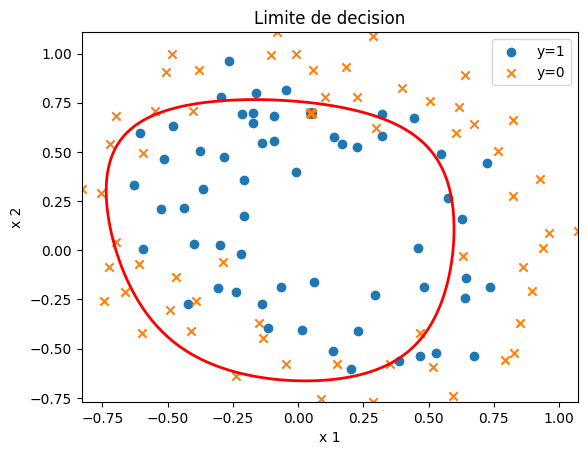

In [16]:
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="y=1",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="y=0",marker ='x')
drawCircle(X2)
plt.xlabel('x 1')
plt.ylabel('x 2')
plt.title('Limite de decision')
plt.legend()

In [17]:
# Avant tranformation polynomiale
from sklearn.metrics import accuracy_score
y_pred = predict(X)
accuracy = accuracy_score(y, y_pred)
print('Accuracy pour X:', accuracy)

Accuracy pour X: 0.5254237288135594


In [30]:
# Après transformation polynomiale
y_pred = predict(X2)
accuracy = accuracy_score(y, y_pred)
print('Accuracy pour X2 (polynomiale):', accuracy)

Accuracy pour X2 (polynomiale): 0.8305084745762712


Traçage du coût en fonction de theta0 et theta1

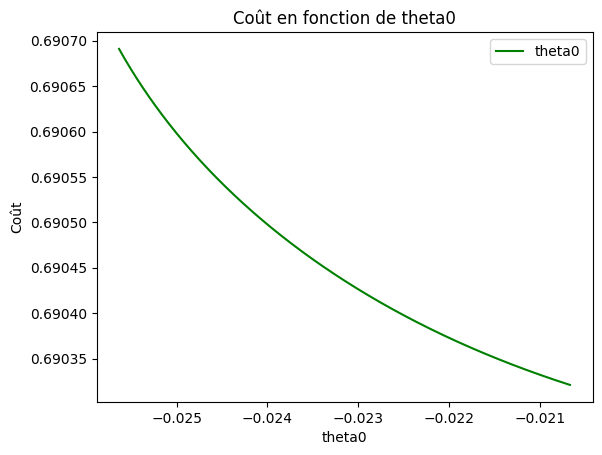

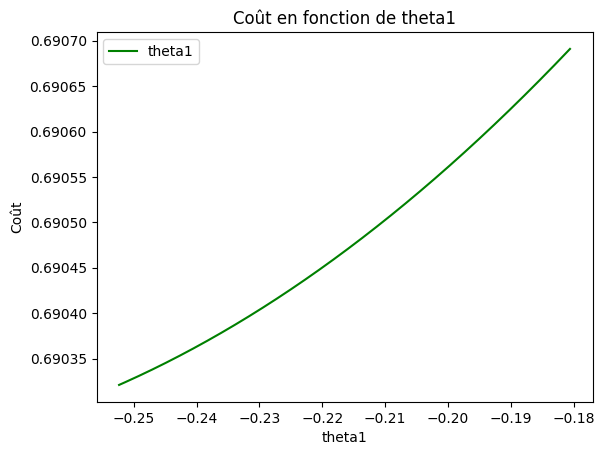

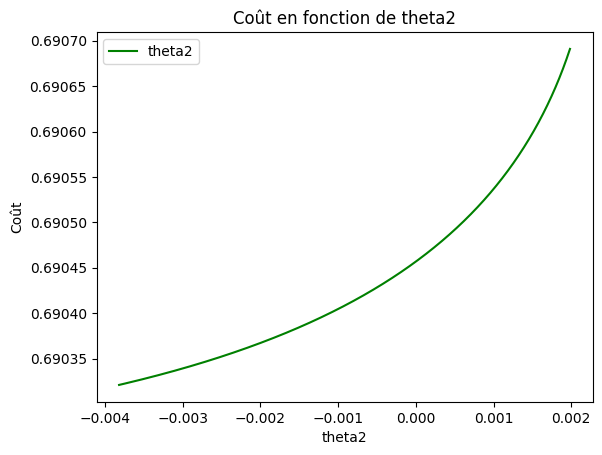

In [19]:
theta, J, theta_history = gradientDescent(X, y, theta, alpha, iterations)

theta_history = np.array(theta_history)  # Just in case it's still a list

n_params = theta_history.shape[1]

for i in range(n_params):
    theta_i = theta_history[:, i]  # Get all values of theta_i over time
    plt.plot(theta_i, J, c='green')
    plt.xlabel(f'theta{i}')
    plt.ylabel('Coût')
    plt.title(f'Coût en fonction de theta{i}')
    plt.legend([f'theta{i}'])
    plt.show()

# Qualité du classifieur

Prédire des valeurs de y

In [20]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred = predict(X)
prcision = np.mean(y==y_pred)*100
print('Precision X:', prcision)
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X2)
y_pred = predict(X2)
prcision2 = np.mean(y==y_pred)*100
print('Precision X2:', prcision2)

Precision X: 52.54237288135594
Precision X2: 73.72881355932203


# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report


# 1. get my Data from the csv file
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,0:2]))
y = data[:, 2]

# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

# 3. Define Hyperparameters
alpha = 0.1
iterations = 10000 
lambda_reg = 0.1 

# --- Custom Model Training & Prediction ---
print("--- Training Custom Model ---")

# Generate polynomial features (degree 6)
X_mapped = mapping(X)

# Initialize thetas
initial_thetas = np.zeros((X_mapped.shape[1], 1))

# Train using Gradient Descent
thetas, J_history, _ = gradientDescent(X_mapped, y, initial_thetas, alpha, iterations, lambda_reg)

# Predictions
y_pred = predict(X_mapped)

# --- Scikit-learn Model Training & Prediction ---
print("\n--- Training Scikit-learn Model ---")

# Logistic Regression with matching parameters
logreg = LogisticRegression(C=1/lambda_reg, max_iter=iterations, fit_intercept=False)
logreg.fit(X_mapped, y)

# Predictions and cost calculation
y_pred_sklearn = logreg.predict(X_mapped)
theta_sklearn = logreg.coef_.reshape(-1, 1)
J_history_sklearn = computeCostReg(X_mapped, y, theta_sklearn, lambda_reg)

# --- Evaluation ---
print("\n--- Evaluation ---")
print(f"Custom Model Thetas: {thetas.flatten()}")
print(f"Scikit-learn Model Thetas: {theta_sklearn.flatten()}")

print(f"Custom Model Cost: {J_history[-1]:.4f}")
print(f"Sklearn Model Cost: {J_history_sklearn:.4f}")

print(f"\nCustom Model Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"Sklearn Model Accuracy: {accuracy_score(y, y_pred_sklearn):.4f}")

print("\nCustom Model Classification Report:")
print(classification_report(y, y_pred))

print("\nSklearn Model Classification Report:")
print(classification_report(y, y_pred_sklearn))


--- Training Custom Model ---

--- Training Scikit-learn Model ---

--- Evaluation ---
Custom Model Thetas: [ 2.64817605  1.77782449  2.80829189 -4.13700166 -3.03663221 -3.84508315
  0.68803682 -1.11616883 -0.76995088 -0.27516631 -3.22039401  0.16729679
 -1.64993099 -1.08471873 -2.66076753 -0.49132425 -0.52916876  0.24278416
 -0.92832915 -1.05542727 -0.35229475 -2.47446323  0.26583042 -0.73735242
  0.20046409 -0.9605957  -0.75896802 -1.4611483 ]
Scikit-learn Model Thetas: [ 2.65911512  1.76049219  2.92184763 -4.02656296 -3.34747042 -4.03454597
  0.7743155  -1.08910539 -0.46732552 -0.48341748 -3.28482805  0.55082834
 -1.80737229 -1.19658242 -2.76723466 -0.61081191 -0.46305231  0.60167153
 -1.14911747 -1.19138309 -0.12444243 -2.66689911  0.47215256 -0.76811156
  0.42277574 -1.16611507 -0.94310905 -1.19671051]
Custom Model Cost: 0.3954
Sklearn Model Cost: 0.3947

Custom Model Accuracy: 0.8305
Sklearn Model Accuracy: 0.8390

Custom Model Classification Report:
              precision    re

c:\Users\moous\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

- Plus de données
- Changer le degree de polynome
- Normaliser les donnees (dans ce cas on ne peut pas car les donnees sont deja sur un echelle)
- Changer les parametres lambda et nbr iterations

# Essayons de changer le degree du polynome de degree 3

In [22]:
def mapping(X):
    
    cols = 10
    degree=3
    outX= np.ones((X.shape[0],cols))
    X1=X[:,1]
    X2=X[:,2]
    k=0
    for i in range(degree):
        for j in range(i+1):
            outX[:, k] = np.power(X1,i-j)*(np.power(X2,j));
            k=k+1
    return outX    


In [23]:
X2 = mapping(X)
X2.shape

(118, 10)

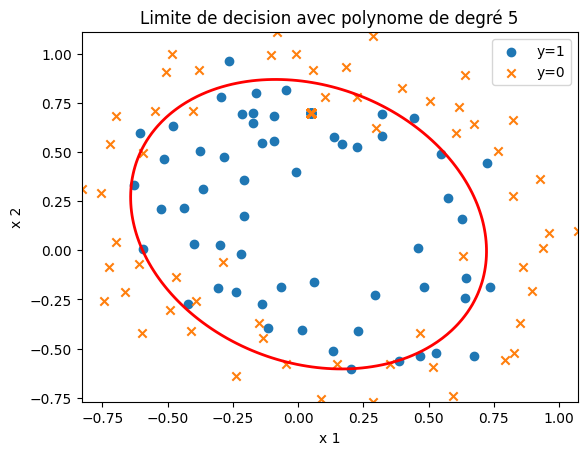

In [24]:
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="y=1",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="y=0",marker ='x')
drawCircle(X2)
plt.xlabel('x 1')
plt.ylabel('x 2')
plt.title('Limite de decision avec polynome de degré 5')
plt.legend()

In [25]:
# Après transformation polynomiale
y_pred = predict(X2)
accuracy = accuracy_score(y, y_pred)
print('Accuracy X2:', accuracy)
y_pred = predict(X)
accuracy = accuracy_score(y, y_pred)
print('Accuracy X2:', accuracy)

Accuracy X2: 0.8135593220338984
Accuracy X2: 0.5423728813559322


# Essayons de modifier le parametre lambda et iterations

In [26]:
lambdaa = 0.1
iterations = 14000
y_pred = predict(X2)

In [27]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y)
accuracy

0.8305084745762712